#Resolución EDP

#Modelo Fisher-Kolmogorov 🧬🦠

Consideramos la ecuación en derivadas parciales (EDP) dada por:
$$
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} + r\,u(1 - u),
$$

donde $u(x,t)$ representa la concentración de células tumorales en función del espacio $x$ y tiempo $t$, $D$ es el coeficiente de difusión y $r$ la tasa de crecimiento logístico.

Se imponen condiciones iniciales con una concentración gaussiana localizada:
$$
u(x,0) = \exp\left(-\frac{(x - L/2)^2}{0.1}\right),
$$
y condiciones de contorno Neumann sin flujo:
$$
\frac{\partial u}{\partial x}(0,t) = \frac{\partial u}{\partial x}(L,t) = 0.
$$

Este modelo es fundamental para describir la propagación y crecimiento de tumores, poblaciones biológicas y fenómenos de reacción-difusión en ciencias naturales. Su solución numérica se obtiene mediante diferencias finitas, mientras que la red neuronal entrenada permite aproximar la solución en todo el dominio espacio-temporal, facilitando predicciones rápidas y análisis comparativos.

Las visualizaciones incluyen la evolución temporal de la concentración, comparaciones entre la solución numérica y la red neuronal, y animaciones de la propagación.

A continuación, definimos el código utilizando *TensorFlow Keras*:




In [ ]:
import numpy as np
import tensorflow as tf                                   # Calculo numerico
from tensorflow.keras import layers, models, optimizers   # Redes neuronales
import matplotlib.pyplot as plt                           # Libreria graficos
from matplotlib.animation import FuncAnimation            # Animaciones
!apt-get install -y ffmpeg
!pip install deepxde
import deepxde as dde
from google.colab import files

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


### Parámetros del modelo:

In [ ]:
# Parámetros del modelo:
D = 0.1            # Coeficiente de difusión
# D = 0.2
# D = 0.6
r = 0.05           # Tasa de crecimiento
# r = 0.07
# r = 1
L = 10             # Longitud del dominio espacial
T = 2              # Tiempo final

X = [0, L]         # Dominio espacial
Tspan = [0, T]     # Dominio temporal

Nx = 100           # Número de puntos espaciales
Nt = 200           # Número de pasos temporales
dx = L / (Nx - 1)  # Paso espacial
dt = T / Nt        # Paso temporal

# Residuo de la ecuación de Fisher-Kolmogorov
def residuo_edp(x, u):
    '''
    Calcula el residuo de la ecuación de Fisher-Kolmogorov:
    u_t = D * u_xx + r * u * (1 - u)
    '''
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    u_xx = dde.grad.hessian(u, x, i=0, j=0)

    return u_t - D * u_xx - r * u * (1 - u)

# Aplicaciones:

def func_inic(x):
    return np.exp(-((x[:, 0:1] - L / 2) ** 2) / 0.1)

def neumann_izquierda(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def neumann_derecha(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

def derivada_espacial_0(x):
    return 0.0

### Método Diferencias Finitas:

In [ ]:
# Condición inicial (una pequeña concentración de células tumorales en el centro)
u = np.zeros((Nx, Nt))
u[:, 0] = np.exp(-((np.linspace(0, L, Nx) - L / 2) ** 2) / 0.1)

In [ ]:
# Solución numérica
for t in range(0, Nt - 1):
    # Condiciones de frontera (no flujo)
    u[0, t + 1] = u[0, t]
    u[-1, t + 1] = u[-1, t]

    # Ecuación de Fisher-Kolmogorov (diferencias finitas)
    for x in range(1, Nx - 1):
        diffusion = D * (u[x + 1, t] - 2 * u[x, t] + u[x - 1, t]) / dx**2
        reaction = r * u[x, t] * (1 - u[x, t])
        u[x, t + 1] = u[x, t] + dt * (diffusion + reaction)

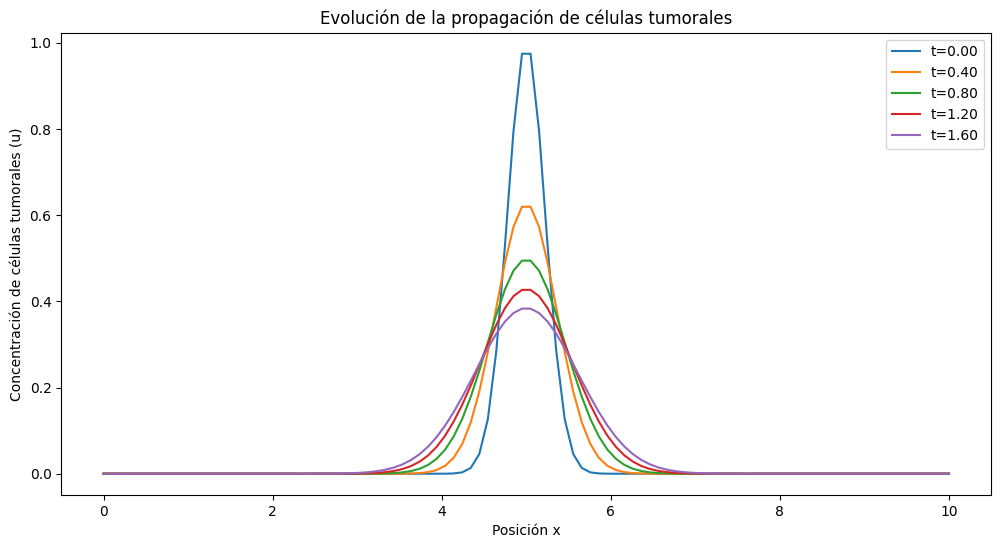

In [ ]:
# Graficar la evolución de la solución en el tiempo
plt.figure(figsize=(12, 6))
for t in range(0, Nt, Nt // 5):
    plt.plot(np.linspace(0, L, Nx), u[:, t], label=f't={t * dt:.2f}')
plt.xlabel('Posición x')
plt.ylabel('Concentración de células tumorales (u)')
plt.title('Evolución de la propagación de células tumorales')
plt.legend()
plt.show()

###PINN:

### Número de puntos de colocación:

In [ ]:
num_coloc_edp = 200              # Puntos interiores (residuo de la EDP)
num_coloc_boundary = 100         # Puntos en la frontera (condiciones de contorno)
num_coloc_initial = 25           # Puntos en t=0 (condición inicial)
number_test = num_coloc_edp      # Puntos para test (por simplicidad)

### Dominio del problema:

In [ ]:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
# Condiciones
bc_left = dde.NeumannBC(geomtime, derivada_espacial_0, neumann_izquierda)
bc_right = dde.NeumannBC(geomtime, derivada_espacial_0, neumann_derecha)
ic = dde.IC(geomtime, func_inic, lambda x, on_initial: on_initial)


# Agrupación de todos los datos acerca del problema
data = dde.data.TimePDE(
    geomtime,
    residuo_edp,
    [ic, bc_left, bc_right],
    num_domain=num_coloc_edp,
    num_boundary=num_coloc_boundary,
    num_initial=num_coloc_initial,
    num_test=number_test,
)

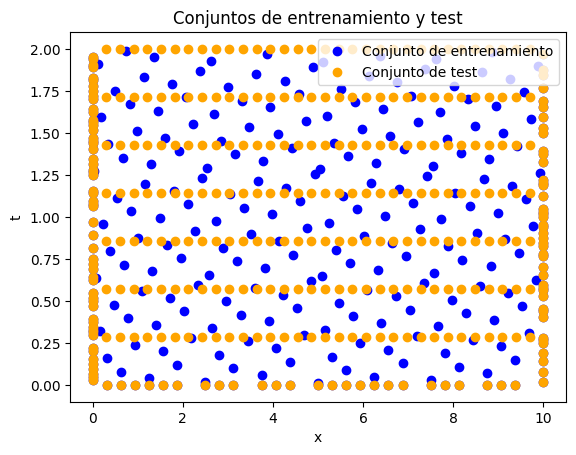

In [ ]:
# Gráfico de los conjuntos de entrenamiento y test
fig, ax = plt.subplots()

ax.plot(data.train_x_all.T[0], data.train_x_all.T[1], "o", color = "blue", label="Conjunto de entrenamiento")
#ax.plot(validating_set.T[0], validating_set.T[1], "ro", label="Conjunto de validación")
ax.plot(data.test_x.T[0], data.test_x.T[1], "o", color = "orange", label="Conjunto de test")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Conjuntos de entrenamiento y test")
ax.legend(loc = "upper right")
plt.show()

### Hiperparámetros:

In [ ]:
layer_size = [2] + [60] * 4 + [1]  # 2 entradas en la capa de entrada, 4 capas ocultas de 60 neuronas cad auna y una quinta con una sola neuronal 1 salida (capa de salida con un único elemento)
activation = "tanh"                # Función de activación "tanh"
learning_rate = 1e-3               # Tasa de aprendizaje
iters = 10000                      # Número de iteraciones del método de optimización
tamanio_lotes = 400                # Tamaño de los "lotes" usados en el entrenamiento
initializer = "Glorot normal"      # Inicializador de pesos (de acuerdo a una distribución de Glorot)

### Construcción modelo PINN:

In [ ]:
net = dde.maps.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

In [ ]:
# DOBLE ENTRENAMIENTO (reduce errores de entrenamiento y de generalización):
# Primer entrenamiento empleando el método Adam.
model.compile("adam", lr=learning_rate, loss='MSE')
loss_history, train_state = model.train(iterations=iters, batch_size = tamanio_lotes)

# Segundo entrenamiento empleando el método L-BFGS.
model.compile("L-BFGS", loss='MSE')
loss_history, train_state = model.train(batch_size = tamanio_lotes)

Compiling model...
Building feed-forward neural network...
'build' took 0.093248 s

'compile' took 0.775732 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.09e-03, 1.34e-01, 3.21e-02, 2.68e-04]    [3.23e-03, 1.34e-01, 3.21e-02, 2.68e-04]    []  
1000      [1.82e-04, 1.27e-04, 9.60e-07, 8.02e-07]    [1.72e-04, 1.27e-04, 9.60e-07, 8.02e-07]    []  
2000      [2.23e-05, 3.95e-06, 1.64e-07, 4.17e-07]    [1.40e-04, 3.95e-06, 1.64e-07, 4.17e-07]    []  
3000      [1.54e-05, 9.45e-05, 6.37e-08, 1.94e-07]    [1.07e-04, 9.45e-05, 6.37e-08, 1.94e-07]    []  
4000      [6.86e-06, 1.63e-06, 4.63e-08, 4.54e-08]    [9.23e-05, 1.63e-06, 4.63e-08, 4.54e-08]    []  
5000      [4.81e-06, 2.22e-06, 3.41e-08, 3.20e-08]    [7.98e-05, 2.22e-06, 3.41e-08, 3.20e-08]    []  
6000      [3.54e-06, 7.06e-07, 3.15e-08, 2.17e-08]    [6.62e-05, 7.06e-07, 3.15e-08, 2.17e-08]    []  
7000      [4.00e-06, 8.56e-06, 1.64e-07

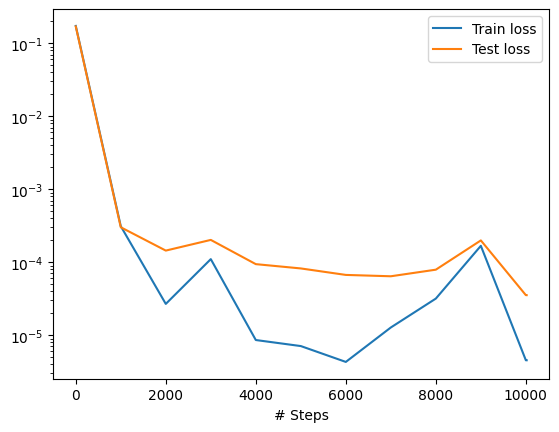

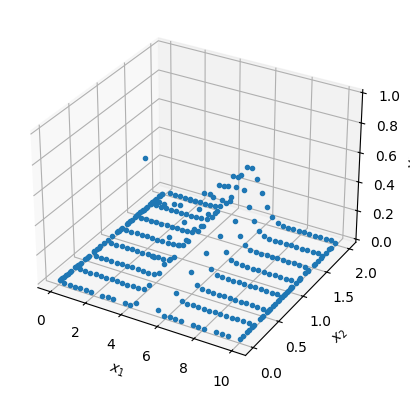

In [ ]:
# Gráficas errores de entrenamiento y generalización
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

### Entrenamiento red neuronal:

In [ ]:
x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)

# Solución numérica: u.shape == (Nx, Nt)

# Evaluar el modelo en una malla compatible, definimos malla (x,t) con Nx x Nt puntos:
X_grid, T_grid = np.meshgrid(x, t)  # T_grid.shape = (Nt, Nx)

# Aplanar para la predicción
XT = np.hstack((X_grid.flatten()[:, None], T_grid.flatten()[:, None]))

# Predecir (model.predict da output en forma (num_puntos, 1))
u_pred_flat = model.predict(XT)

# Reshape para que coincida con la malla (Nt, Nx)
u_pred = u_pred_flat.reshape(Nt, Nx)

# Para comparar con u que está (Nx, Nt), trasponemos
u_df = u.T                          # u_df.shape = (Nt, Nx)

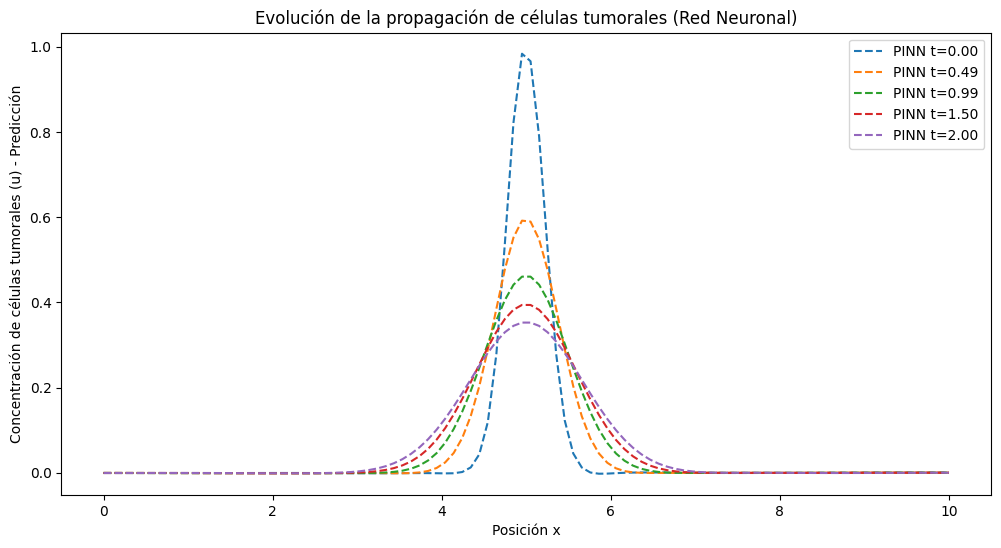

In [ ]:
# Graficar la predicción de la red neuronal
plt.figure(figsize=(12, 6))
for time_idx in np.linspace(0, Nt-1, 5, dtype=int):  # 5 tiempos muestreados
    plt.plot(x, u_pred[time_idx, :], '--', label=f'PINN t={t[time_idx]:.2f}')
plt.xlabel('Posición x')
plt.ylabel('Concentración de células tumorales (u) - Predicción')
plt.title('Evolución de la propagación de células tumorales (Red Neuronal)')
plt.legend()
plt.show()

### COMPARACIÓN:

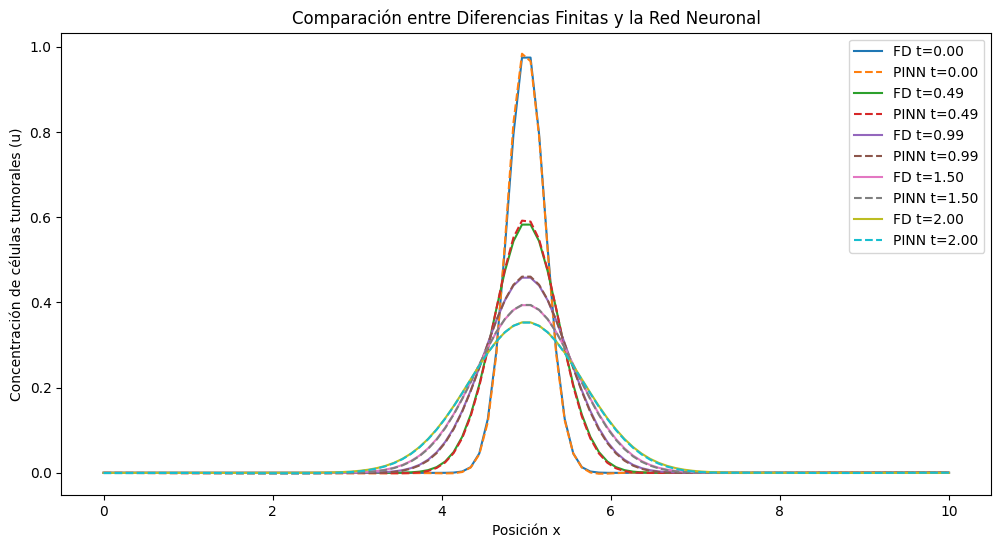

In [ ]:
# Graficar la comparación de la solución por diferencias finitas y la predicción de la red neuronal
plt.figure(figsize=(12, 6))
for time_idx in np.linspace(0, Nt-1, 5, dtype=int):  # 5 tiempos muestreados
    plt.plot(x, u_df[time_idx, :], label=f'FD t={t[time_idx]:.2f}')
    plt.plot(x, u_pred[time_idx, :], '--', label=f'PINN t={t[time_idx]:.2f}')
plt.xlabel('Posición x')
plt.ylabel('Concentración de células tumorales (u)')
plt.title('Comparación entre Diferencias Finitas y la Red Neuronal')
plt.legend()
plt.show()

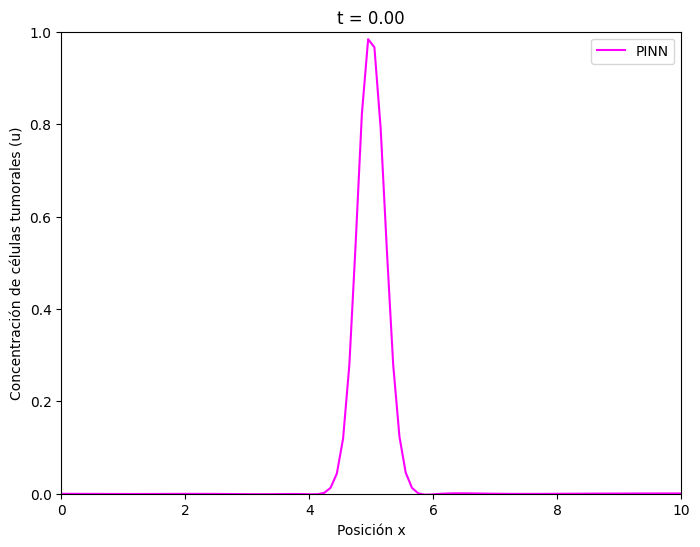

In [ ]:
# Crear el gráfico para la animación
fig, ax = plt.subplots(figsize=(8, 6))
x = np.linspace(0, L, Nx)
line, = ax.plot(x, u_pred[0, :], color='fuchsia', label="PINN")
title = ax.set_title("t = 0.00")
ax.set_xlim(0, L)
ax.set_ylim(0, 1)
ax.set_xlabel("Posición x")
ax.set_ylabel("Concentración de células tumorales (u)")
ax.set_title("Evolución de la propagación de células tumorales")
ax.legend()

def update(frame):
    line.set_ydata(u_pred[frame, :])  # Correcto: shape (100,)
    title.set_text(f"t = {t[frame]:.2f}")
    return line, title

ani = FuncAnimation(fig, update, frames=range(0, Nt, 5), interval=100)

# Guardar como MP4
ani.save('propagacion_cancer_fisher_kolmogorov.mp4', writer='ffmpeg', fps=30)

In [ ]:
# Mostrar el video (esto es opcional en entornos locales)
plt.show()

In [ ]:
files.download('/content/propagacion_cancer_fisher_kolmogorov.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>